In [209]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

In [210]:
def process_age(df):
    '''
    Returns Dataframe with age column replaced by age categories.
    '''
    cut_points = [-1,0, 5, 12, 18, 35, 55, 100]
    label_names = ["Missing", 'Infant', "Child", 'Teenager', "Young Adult", 'Adult', 'Senior']
    df["Age"] = df["Age"].fillna(-0.5)
    df['AgeCategory'] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df.drop(['Age'], axis=1)


def process_fare(df):
    '''
    Returns Dataframe with fare column replaced by fare categories.
    '''
    df.Fare.fillna(df.Fare.mode()[0], inplace=True)
    cut_points = [-1, 0.1, 50, 100]
    label_names = ["Zero", "Low", "High"]        
    df['FareCategory'] = pd.cut(df["Fare"], cut_points, labels=label_names)
    return df.drop(['Fare'], axis=1)


def process_name(df):
    '''
    Returns Dataframe with title column replaced by title categories.
    '''
    def get_title(name):
        return name.split(',')[1].split()[0]
    
    def get_sirname(name):
        return name.split(',')[0]

    def get_title_group(title):
        vips = ['Dr.', 'Rev.', 'Col.', 'Major.', 'Sir.', 'Lady.', 'Don.', 'Capt.', 'Jonkheer.', 'the']
        children = ['Master.']
        women = ['Miss.', 'Mrs.', 'Ms.']
        men = ['Mr.']
        if title in vips:
            return 'VIP'
        elif title in children: 
            return 'Child'
        elif title in women:
            return 'Woman'
        else:
            return 'Man'
    df['Title'] = df.Name.apply(get_title)
    df['TitleCategory'] = df.Title.apply(get_title_group)
    return df.drop(['Name', 'Title'], axis=1)
    
def process_cabin(df):
    '''
    Returns Dataframe with cabin column replaced by cabin/no cabin categories.
    '''
    def get_cabin_group(cabin):
        if cabin is not np.nan:
            return 'Cabin'
        else:
            return 'No Cabin'
    df['CabinCategory'] = df.Cabin.apply(get_cabin_group)
    return df.drop(['Cabin'], axis=1)


def encode(series):
    '''
    Returns a numerically-encoded list of a categorical data Series.
    '''
    unique = pd.unique(series)
    categs = {}
    for index, item in enumerate(unique):
        categs[item] = index
    encoded = []
    for index in series:
        encoded.append(categs[index])
    return encoded

def create_dummies(df, column_name):
    '''
    Returns Dataframe with categorical column replaced by a set of one-hot-encoded columns
    '''
    dummies = pd.get_dummies(df[column_name], prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

def condition_data(df):
    '''
    Returns Dataframe conditioned into machine-learning appropriate representation
    '''
    df = process_age(df)
    df = process_fare(df)
    df = process_name(df)
    df = process_cabin(df)
    df['Sex'] = encode(df.Sex)
    for col in ['Embarked', 'Pclass', 'AgeCategory', 'FareCategory', 'TitleCategory', 'CabinCategory']:
        df = create_dummies(df, col)
        df = df.drop([col], axis=1)
    df = df.drop(['Ticket'], axis=1)
    #data = data.dropna(subset=['Sex'])
    return df

def generate_submission():
    '''
    1. Trains and evaluates a Random Forest model on conditioned training data.
    2. Generates predictions and returns Dataframe in Kaggle submission format
    '''
    #Train model
    data_train = pd.read_csv('./train.csv')
    conditioned_data = condition_data(data_train)

    model = RandomForestClassifier(n_estimators=20)
    scores = cross_val_score(model, conditioned_data.drop(['PassengerId', 'Survived'], axis=1), conditioned_data.Survived, cv=5)
    print('ML model CV score mean: {:.2f}'.format(np.mean(scores)))   
    model.fit(conditioned_data.drop(['PassengerId', 'Survived'], axis=1), conditioned_data.Survived)

    #Generate Predictions
    data_test = pd.read_csv('./test.csv')
    conditioned_data_test = condition_data(data_test)
    
    predictions = model.predict(conditioned_data_test.drop(['PassengerId'], axis=1))
    submission = pd.DataFrame({'PassengerId': conditioned_data_test.PassengerId.values, 'Survived': predictions})

    return submission

submission = generate_submission()
submission.to_csv('submission.csv', index=False)

ML model CV score mean: 0.80


### Data Exploration

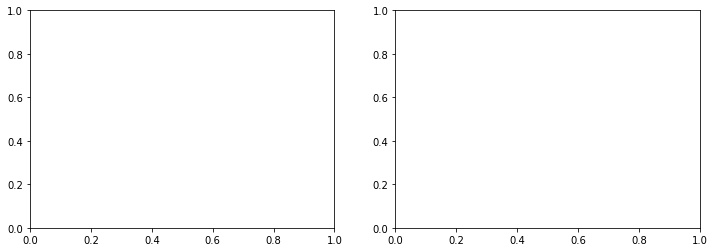

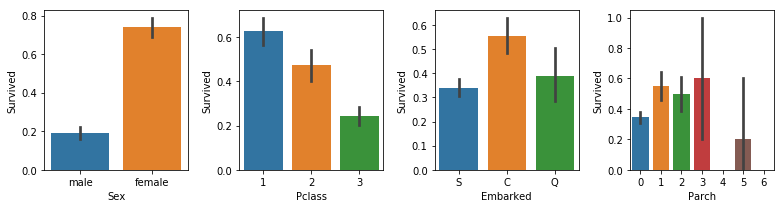

In [211]:
train, test = pd.read_csv('./train.csv'), pd.read_csv('./test.csv')

test = test.dropna(subset=['Fare'])

fig, ax = plt.subplots(1, 4, figsize=(11,3))
sns.barplot(x='Sex', y='Survived', data=train, ax=ax[0])
sns.barplot(x='Pclass', y='Survived', data=train, ax=ax[1])
sns.barplot(x='Embarked', y='Survived', data=train, ax=ax[2])
sns.barplot(x='Parch', y='Survived', data=train, ax=ax[3])

plt.tight_layout()
plt.show()

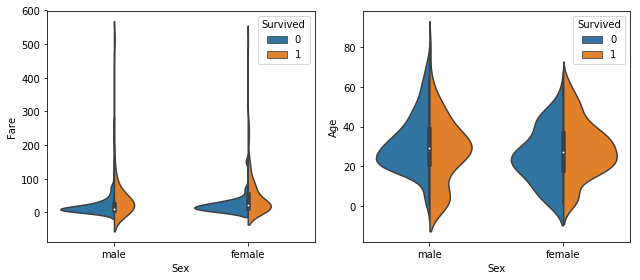

In [212]:
fig, ax = plt.subplots(1, 2, figsize=(9,4))

sns.violinplot(x='Sex', y='Fare', hue='Survived', data=data, split=True, ax=ax[0])
sns.violinplot(x='Sex', y='Age', hue='Survived', data=data, split=True, ax=ax[1])

plt.tight_layout()
plt.show()

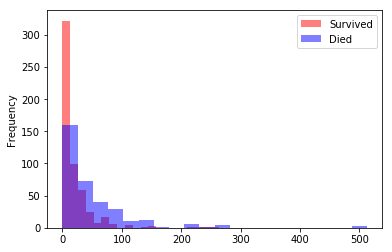

In [213]:
died = train[train.Survived == 1]
surv = train[train.Survived == 0]

surv["Fare"].plot.hist(alpha=0.5,color='red',bins=20, label='Survived')
died["Fare"].plot.hist(alpha=0.5,color='blue',bins=20, label='Died')
plt.legend()

plt.show()

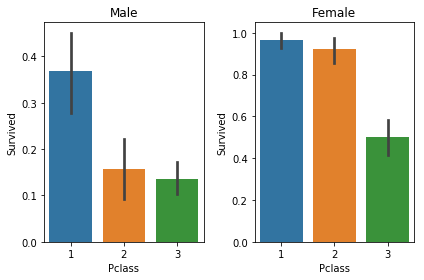

In [214]:
fig, ax = plt.subplots(1, 2)

male = train[train.Sex == 'male']
female = train[train.Sex == 'female']

sns.barplot(x='Pclass', y='Survived', data=male, ax=ax[0])
sns.barplot(x='Pclass', y='Survived', data=female, ax=ax[1])

ax[0].set_title('Male')
ax[1].set_title('Female')

plt.tight_layout()
plt.show()

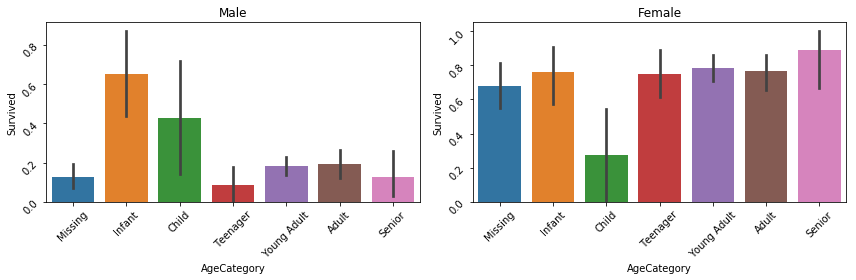

In [221]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

processed = process_age(train)

male = train[processed.Sex == 'male']
female = train[processed.Sex == 'female']

sns.barplot(x='AgeCategory', y='Survived', data=male, ax=ax[0])
sns.barplot(x='AgeCategory', y='Survived', data=female, ax=ax[1])

ax[0].set_title('Male')
ax[1].set_title('Female')

ax[0].tick_params(rotation=45)
ax[1].tick_params(rotation=45)

plt.tight_layout()
plt.show()